# 1. 분석 주제

### 1) 분석 배경

* 금번 2020 미국 대선에서 모든 언론은 바이든의 압승을 예상했음
* Shy Trump에 대한 우려도 존재했으나, 2016년 대선 예측 실패를 교훈 삼아 보정했다는 의견이 다수
* But, 그럼에도 불구하고 바이든 당선인의 승리는 압승이 아닌 신승에 가까웠음
* 개인 프로젝트에서 어떤 부분에서 언론사 예측에서 문제가 있었는 지 파악하고자 함

### 2) 분석 방법

* 고민 중 (일단, 마음가는대로)
* 향후 인구 구성 및 경제 수준 관련 자료를 가지고 추가 분석 필요
* 예측 데이터는 fivethirtyeight 데이터 참고 (https://data.fivethirtyeight.com/)

# 2. 데이터 분석

### 1) Import Library

In [1]:
import csv
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import re
import os, sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
def mean_absolute_percent_error(y_true, y_pred) :
    return np.mean(np.abs((y_true - y_pred)/y_true))

def mean_percent_error(y_true, y_pred) :
    return np.mean((y_true-y_pred)/y_true)

### 2) Load forecast data (from FiveThirtyEight)

In [3]:
base_dir = os.getcwd()
election_dir = os.path.join(base_dir,'election-forecasts-2020')
for i in os.listdir(election_dir) :
    print(i)

economic_index.csv
electoral_college_vs_popvote.csv
house_district_toplines_2020.csv
house_fundamentals.csv
house_national_toplines_2020.csv
house_seat_distribution.csv
house_steps.csv
joint_probabilities.csv
presidential_ev_probabilities_2020.csv
presidential_forecast_steps.csv
presidential_national_toplines_2020.csv
presidential_polls_2020.csv
presidential_poll_averages_2020.csv
presidential_scenario_analysis_2020.csv
presidential_state_toplines_2020.csv
README.md
senate_fundamentals.csv
senate_national_toplines_2020.csv
senate_seat_distribution.csv
senate_state_toplines_2020.csv
senate_steps.csv


In [4]:
df_fcst = pd.read_csv(os.path.join(election_dir, 'presidential_state_toplines_2020.csv'))
df_fcst.head()

,cycle,branch,model,modeldate,candidate_inc,candidate_chal,candidate_3rd,state,tipping,vpi,...,margin_lo,win_EC_if_win_state_inc,win_EC_if_win_state_chal,win_state_if_win_EC_inc,win_state_if_win_EC_chal,state_turnout,state_turnout_hi,state_turnout_lo,timestamp,simulations
0,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Wyoming,0.000000,0.000000,...,24.50582,0.104044,0.984615,0.999759,0.001795,274642.0,319577.0,231459.0,00:00:48 3 Nov 2020,40000
1,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Wisconsin,0.053137,2.543351,...,-14.89797,0.771821,0.931934,0.419153,0.986261,3325739.0,3748885.0,2908762.0,00:00:48 3 Nov 2020,40000
2,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,West Virginia,0.000063,0.015240,...,18.01854,0.104550,0.986063,0.999038,0.007935,749616.0,868161.0,635685.0,00:00:48 3 Nov 2020,40000
3,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Washington,0.002288,0.082997,...,-34.12025,0.263314,0.892971,0.021415,0.993074,4429891.0,5013615.0,3857496.0,00:00:48 3 Nov 2020,40000
4,2020,President,polls-plus,11/3/2020,Trump,Biden,NaN,Virginia,0.009850,0.341279,...,-18.56248,0.767263,0.898129,0.072185,0.997476,4599938.0,5189515.0,4020238.0,00:00:48 3 Nov 2020,40000


In [5]:
# table pivotting
pi_fcst = df_fcst.groupby(['modeldate', 'state'])['voteshare_inc', 'voteshare_chal'].mean().unstack('modeldate')

# creat column list
col_name = []
for i in pi_fcst.columns :
    if 'inc' in i[0] :
        col_name.append('inc_'+ i[1])
    else :
        col_name.append('chal_'+ i[1])

# column renamming
pi_fcst.columns = col_name
inc_col = [i for i in col_name if 'inc' in i]
chal_col = [i for i in col_name if 'chal' in i]

pi_fcst.reset_index(inplace=True)

### 3) Election results crawling

In [6]:
html = urlopen('https://en.wikipedia.org/wiki/2020_United_States_presidential_election')
bs = BeautifulSoup(html, 'html.parser')

table = bs.findAll('table', {'class':'wikitable'})[13]
rows = table.findAll('tr')

In [7]:
# Load election results
df = {}

#try :
colRow = []
for n, row in enumerate(rows) :  
    csvRow = []
    for n2, cell in enumerate(row.findAll(['td', 'th'])) : # td는 table data, th는 table header
        if n2 in [0,1,2,4,5] :
            csvRow.append(cell.get_text())
        else :
            pass
        #print(csvRow)
    #writer.writerow(csvRow)
    if n < 2 :
        pass
    else :
        df[str(n)] = csvRow
        
res_df = pd.DataFrame(df).T
real_res = res_df.reset_index().drop('index',1)\
.rename(columns={0:'State', 1:'Biden_Votes', 2:'Biden_%', 3:'Trump_Votes', 4:'Trump_%'}).drop([56, 57], 0)

In [8]:
real_res.head()

,State,Biden_Votes,Biden_%,Trump_Votes,Trump_%
0,Ala.,"849,624",36.57%,"1,441,170",62.03%
1,Alaska,"153,778",42.77%,"189,951",52.83%
2,Ariz.,"1,672,143",49.36%,"1,661,686",49.06%
3,Ark.,"423,932",34.78%,"760,647",62.40%
4,Calif.,"11,110,250",63.48%,"6,006,429",34.32%


In [9]:
real_res.to_csv('crawling_election_data.csv')

### 4) Data Cleansing

In [10]:
# Load state's full name

table = bs.findAll('table', {'class':'wikitable'})[10]
rows = table.findAll('tr')

df = {}

#try :
csvRow = []
for n, row in enumerate(rows) :  
    for n2, cell in enumerate(row.findAll(['td', 'th'])) : # td는 table data, th는 table header
        if n2 in [0] :
            csvRow.append(cell.get_text().strip('\n'))
            
csvFin = csvRow[2:-1]

In [11]:
# change state name
real_res['State'] = csvFin

In [12]:
real_res.head()

,State,Biden_Votes,Biden_%,Trump_Votes,Trump_%
0,Alabama,"849,624",36.57%,"1,441,170",62.03%
1,Alaska,"153,778",42.77%,"189,951",52.83%
2,Arizona,"1,672,143",49.36%,"1,661,686",49.06%
3,Arkansas,"423,932",34.78%,"760,647",62.40%
4,California,"11,110,250",63.48%,"6,006,429",34.32%


In [13]:
real_res['Biden_%'] = real_res['Biden_%'].apply(lambda x : float(x.strip('%')))
real_res['Trump_%'] = real_res['Trump_%'].apply(lambda x : float(x.strip('%')))

real_res.rename(columns = {'State':'state'}, inplace=True)

In [14]:
# check merge error
print('null check:',pd.merge(real_res, pi_fcst, on = 'state').isnull().sum().sum())
print('shape check:', pd.merge(real_res, pi_fcst, on = 'state').shape)

all_df = pd.merge(real_res, pi_fcst, on = 'state')

null check: 0
shape check: (56, 317)


In [15]:
# Calculate the mape

b_mape = []
b_mpe = []
for i in chal_col :
    b_mape.append(mean_absolute_percent_error(all_df['Biden_%'], all_df[i]))
    b_mpe.append(mean_percent_error(all_df['Biden_%'], all_df[i]))

t_mape = []
t_mpe = []
for i in inc_col :
    t_mape.append(mean_absolute_percent_error(all_df['Trump_%'], all_df[i]))
    t_mpe.append(mean_percent_error(all_df['Trump_%'], all_df[i]))

# creat the index
dt_col = []
for i in chal_col :
    dt_col.append(i.strip('chal_'))

# creat the df
mape_df = pd.DataFrame({'date':dt_col,'b_mape': b_mape, 'b_mpe':b_mpe,'t_mape':t_mape, 't_mpe':t_mpe})
mape_df['date'] = pd.to_datetime(mape_df['date'])

mape_df.index = mape_df['date']
mape_df.drop('date',1,inplace=True)
mape_df.sort_index(inplace=True)

In [71]:
# f, ax = plt.subplots(1,1, figsize=(16,7))
# sns.lineplot(x=mape_df.index, y=mape_df['b_mape'], ax=ax)
# sns.lineplot(x=mape_df.index, y=mape_df['t_mape'], ax=ax)
# ax.fill_between(mape_df.index,mape_df['b_mape'], mape_df['t_mape'], color='grey', alpha='0.1')
# ax.yaxis.grid(False)
# ax.set_title('MAPE Gap', fontsize=20)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['left'].set_visible(False)
# #ax.axis('off')

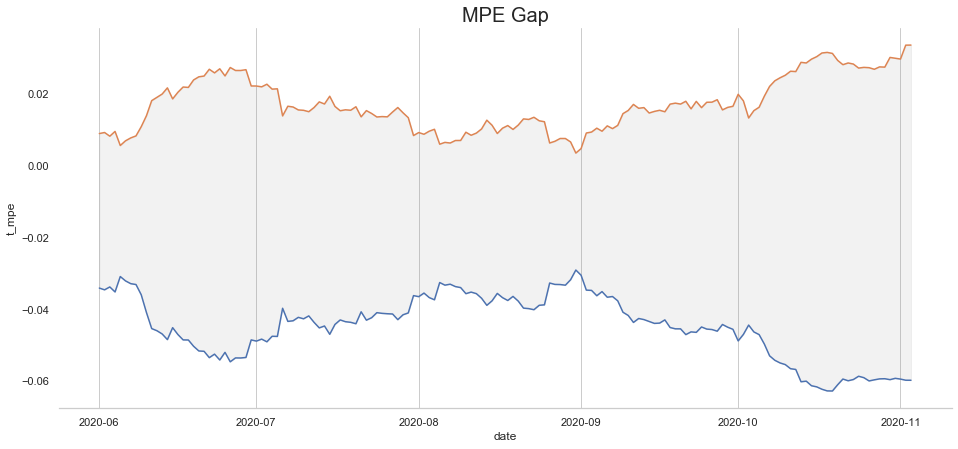

In [17]:
f, ax = plt.subplots(1,1, figsize=(16,7))
sns.lineplot(x=mape_df.index, y=mape_df['b_mpe'], ax=ax)
sns.lineplot(x=mape_df.index, y=mape_df['t_mpe'], ax=ax)
ax.fill_between(mape_df.index,mape_df['b_mpe'], mape_df['t_mpe'], color='grey', alpha='0.1')
ax.yaxis.grid(False)
#ax.yaxis.grid(color='light grey', linewidth=1)
ax.set_title('MPE Gap', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

* 일관되게 Biden 당선인의 mape는 높았고, trump 당선인의 mape는 낮았음
* 심지어 마지막 시점 11/3에는 바이든은 주 평균, 2% point 이상 과대 예측되고, 트럼프는 6% point 정도 과소 예측되었음
* shy trump가 이번에도 존재했다는 것을 확인 가능

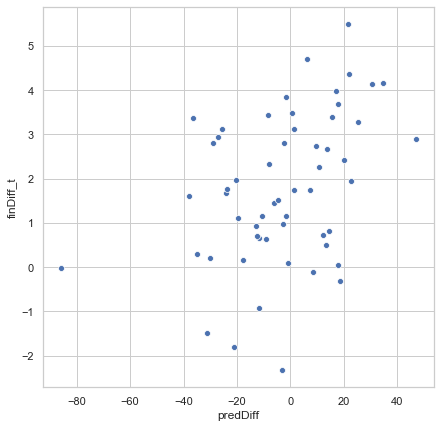

In [18]:
i_fin = 'inc_11/3/2020'
c_fin = 'chal_11/3/2020'

all_df['finDiff_b'] = all_df['Biden_%'] - all_df[c_fin]
all_df['finDiff_t'] = all_df['Trump_%'] - all_df[i_fin] 
all_df['predDiff'] = all_df[i_fin] - all_df[c_fin]
all_df['resDiff'] = all_df['Trump_%'] - all_df['Biden_%']

plt.figure(figsize=(7,7))
sns.scatterplot(all_df['predDiff'], all_df['finDiff_t'])
#sns.scatterplot(all_df['finDiff_b'], all_df['resDiff'])

In [19]:
all_df[['predDiff', 'finDiff_t']].corr()

,predDiff,finDiff_t
predDiff,1.00000,0.38832
finDiff_t,0.38832,1.00000


* 트럼프와 바이든 후보의 격차가 클수록 트럼프 실제와 예측간 결과도 컸다는 것을 볼 수 있음 
* 정리하자면, 예측시 트럼프와 바이든 후보 격차가 클수록 여론조사에서 잡아내지 못한 '샤이 트럼프' 규모도 컸던 거 같음
* 다만 차이가 컸지만 오차는 거의 0% point인 washington 특별구도 존재

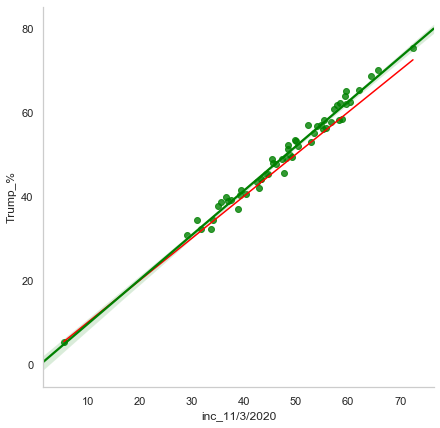

In [20]:
f, ax = plt.subplots(1,1, figsize=(7,7))
sns.lineplot( all_df[i_fin], all_df[i_fin],ax=ax, c='red')
sns.regplot(all_df[i_fin], all_df['Trump_%'], color='green')
#sns.scatterplot(all_df[i_fin],all_df['Trump_%'],  ax=ax)
ax.grid(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['left'].set_visible(False)


* 위 그래프를 보면, 트럼프 예측이 높을 수록 실제 결과가 기울기 1인 빨간 직선 위로 더 높게 형성되어있음
* 실제로 두 변수의 회귀선은 기울기가 1보다 조금 높음을 볼 수 있음

### Demographic analysis (gender, household income, races)

* income, races, poverty data from KFF
* gender ratio data from https://worldpopulationreview.com/state-rankings/male-to-female-ratio-by-state

In [184]:
g_df = pd.read_csv('gender ratio.csv')
i_df = pd.read_csv('income.csv')
r_df = pd.read_csv('races.csv')
p_df = pd.read_csv('poverty.csv')
# drop the useless data and rename value
g_df.loc[g_df['State'] == 'Washington DC', 'State' ] = 'District of Columbia'
r_df = r_df.iloc[1:, ]
i_df = i_df.iloc[1:,]
p_df = p_df.iloc[1:,]
p_list = [i+'_poverty' for i in p_df.columns[1:]]
p_df.columns = ['Location']+ [i+'_poverty' for i in p_df.columns[1:]]


# merge dataframe
d_df = pd.merge(g_df, i_df, left_on='State', right_on='Location')
d_df = pd.merge(d_df, r_df, on='Location')
d_df = pd.merge(d_df, p_df, on = 'Location')
d_df.drop('Location', 1, inplace=True)

# object value convert to numeric data
d_df['Median Annual Household Income'] = pd.to_numeric(d_df['Median Annual Household Income'].str.replace('$', '').str.replace(',',''))
d_df['Native Hawaiian/Other Pacific Islander']= pd.to_numeric(d_df['Native Hawaiian/Other Pacific Islander'], errors='coerce')
d_df.rename(columns= {'State' : 'state'}, inplace=True)

In [185]:
all_df2 = pd.merge(all_df, d_df, on='state', how='left')

In [186]:
d_list = ['SexRatio', 'Median Annual Household Income', 'White', 'Black',
       'Hispanic', 'Asian', 'American Indian/Alaska Native',
       'Native Hawaiian/Other Pacific Islander', 'Multiple Races']

In [187]:
# all_df2.loc[all_df2['state'] == 'ME-1', d_list+p_list] = all_df2.loc[all_df2['state'] == 'Maine', d_list+p_list].values
# all_df2.loc[all_df2['state'] == 'ME-2', d_list+p_list] = all_df2.loc[all_df2['state'] == 'Maine', d_list+p_list].values
# all_df2.loc[all_df2['state'] == 'NE-1', d_list+p_list] = all_df2.loc[all_df2['state'] == 'Nebraska', d_list+p_list].values
# all_df2.loc[all_df2['state'] == 'NE-2', d_list+p_list] = all_df2.loc[all_df2['state'] == 'Nebraska', d_list+p_list].values
# all_df2.loc[all_df2['state'] == 'NE-3', d_list+p_list] = all_df2.loc[all_df2['state'] == 'Nebraska', d_list].values

In [188]:
all_df2['Income_minmax'] = (all_df2['Median Annual Household Income'] - all_df2['Median Annual Household Income'].min()) / (all_df2['Median Annual Household Income'].max() - all_df2['Median Annual Household Income'].min())

In [189]:
d_list2 = []
for i in [i for i in d_list if i != 'Median Annual Household Income'] :
    all_df2[i+'_income'] = all_df2[i] * all_df2['Income_minmax']
    d_list2.append(i+'_income')   

In [190]:
all_df2.corr()['finDiff_t'][d_list+d_list2+p_list].sort_values(ascending=False)

White                                                 0.388239
Native Hawaiian/Other Pacific Islander_income         0.350384
Native Hawaiian/Other Pacific Islander                0.350303
Multiple Races_poverty                                0.350058
White_poverty                                         0.346264
American Indian/Alaska Native_poverty                 0.307248
Black_poverty                                         0.288785
SexRatio                                              0.244869
Hispanic_poverty                                      0.238218
Asian/Native Hawaiian and Pacific Islander_poverty    0.223344
American Indian/Alaska Native                         0.090285
Total_poverty                                         0.052786
Multiple Races                                        0.051823
American Indian/Alaska Native_income                 -0.042255
Multiple Races_income                                -0.064830
Asian                                                -0

* 확인하면, 우선적으로 큰 상관관계가 있는 변수는 관찰되지 않음
* 다만, 어느 정도 상관관계가 있는 것으로 보이는 변수가 몇 있음
* 특히, Black과 Black_income은 약 -0.36~-0.38 정도의 상관관계를 보임 
* 해석하자면, 흑인 비율이 높고, 흑인비율과 median income 소득을 곱한 값이 높을 수록 Trump 후보의 실제-예측 격차는 작아지거나 음수가 된다는 것
    * 위와 같은 주에서는 shy trump가 적고 오히려 과대 예측되었을 수도 있다는 것
    * Hispanic도 비슷
* 반대로, 백인 비율이 높은 주에서는 오히려 반대의 현상이 나타났음
* 물론, 이렇게 간단한 분석으로 해당 관계를 보긴 어려울 수 있음

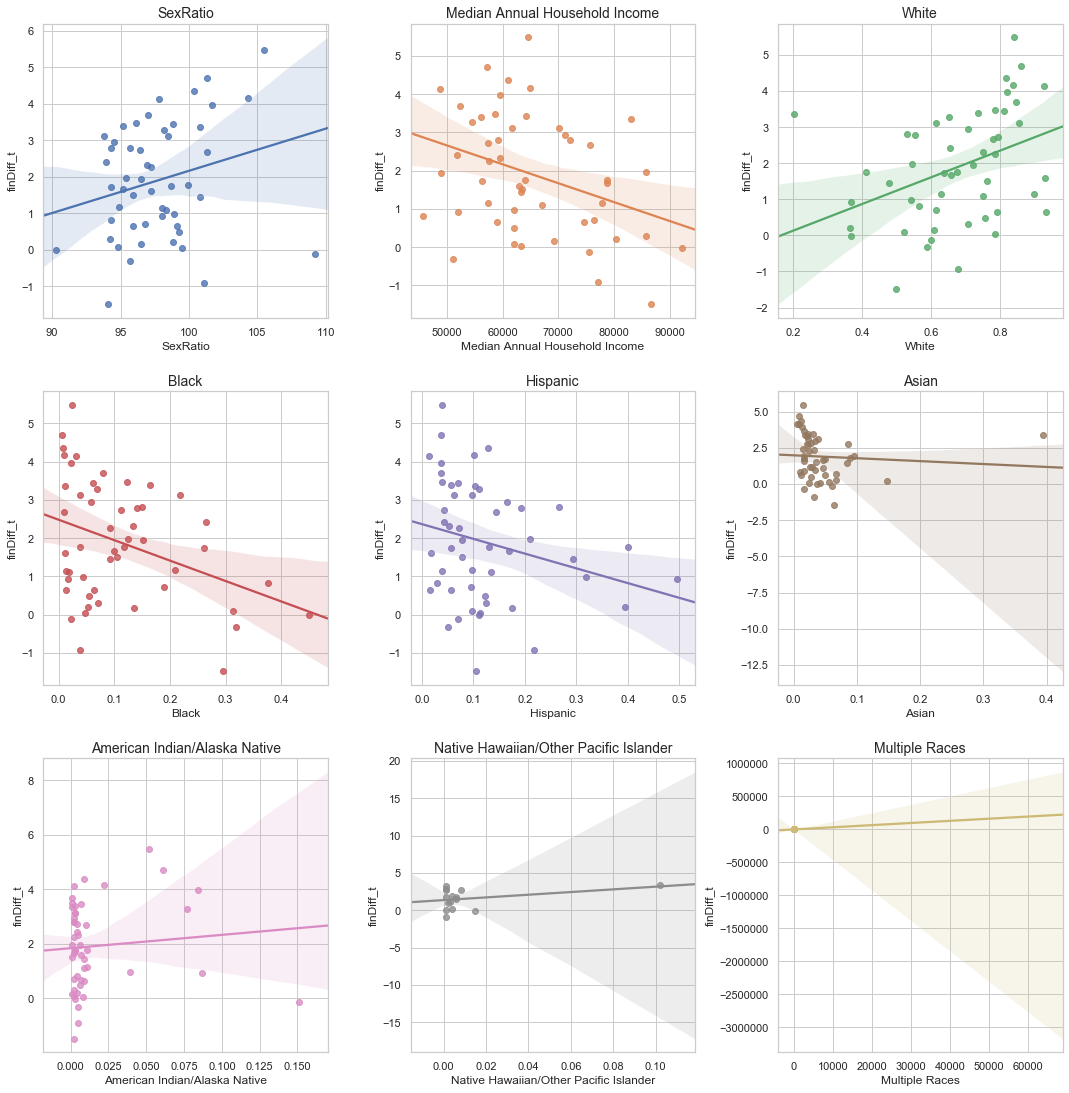

In [191]:
f, ax = plt.subplots(3, 3, figsize=(16,16))
ax = ax.flatten()
f.tight_layout(pad=5)

for n, i in enumerate(d_list) :
    sns.regplot(x=i, y='finDiff_t', data=all_df2, ax=ax[n])
    ax[n].set_title(i, fontsize=14)

* 위 그래프를 보면, 백인 인구 비율을 보여주는 'White'에서는 어느 정도 경향성이 보이나,
* 흑인 인구 비율을 보여주는 'Black'에서는 오른쪽 아래 쳐져있는 몇 개구에서 상관관계를 주도한 것으로 보임 (hispanic도 유사)
* Income은 상대적으로 명확한 관계를 보임
* 해당 그래프는 더욱더 깊은 분석이 필요함을 보여줌

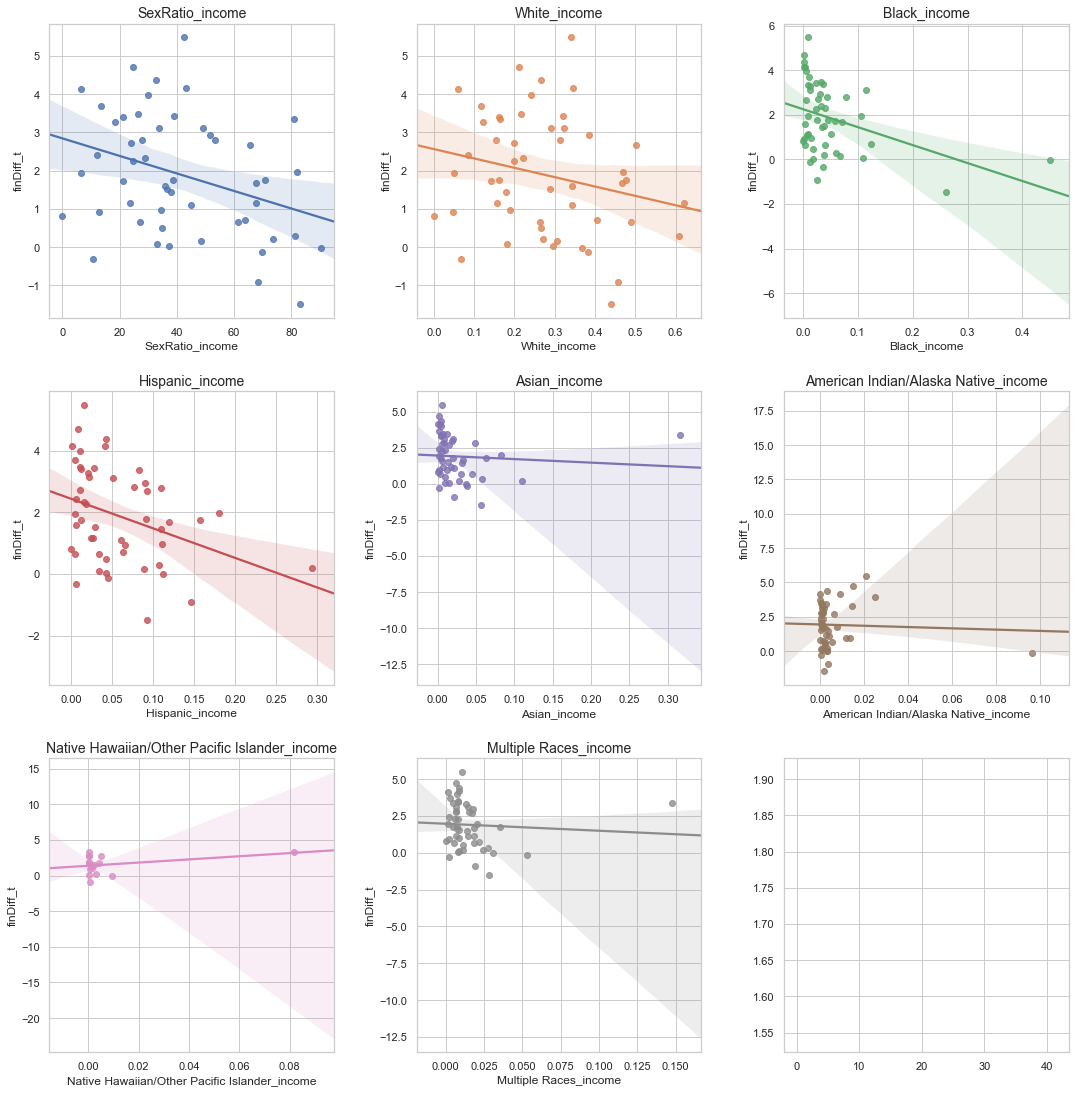

In [192]:
f, ax = plt.subplots(3, 3, figsize=(16,16))
ax = ax.flatten()
f.tight_layout(pad=5)

for n, i in enumerate(d_list2) :
    sns.regplot(x=i, y='finDiff_t', data=all_df2, ax=ax[n])
    ax[n].set_title(i, fontsize=14)

* median income을 각 인종별 비율에 곱합 그래프
* Black_income의 경우 위 그래프에 비해 더욱더 우하향하는 모습을 보이지만 위와 동일하게 오른쪽 쳐져있는 몇개구가 기울기를 쳐지게 하는 것으로 보임
* Sex ratio의 경우, 0.24였지만, income을 곱한 이후에는 -0.340628로 관계가 반대의 관계를 보임
* 해당 그래프는 해석에 유의해야 함

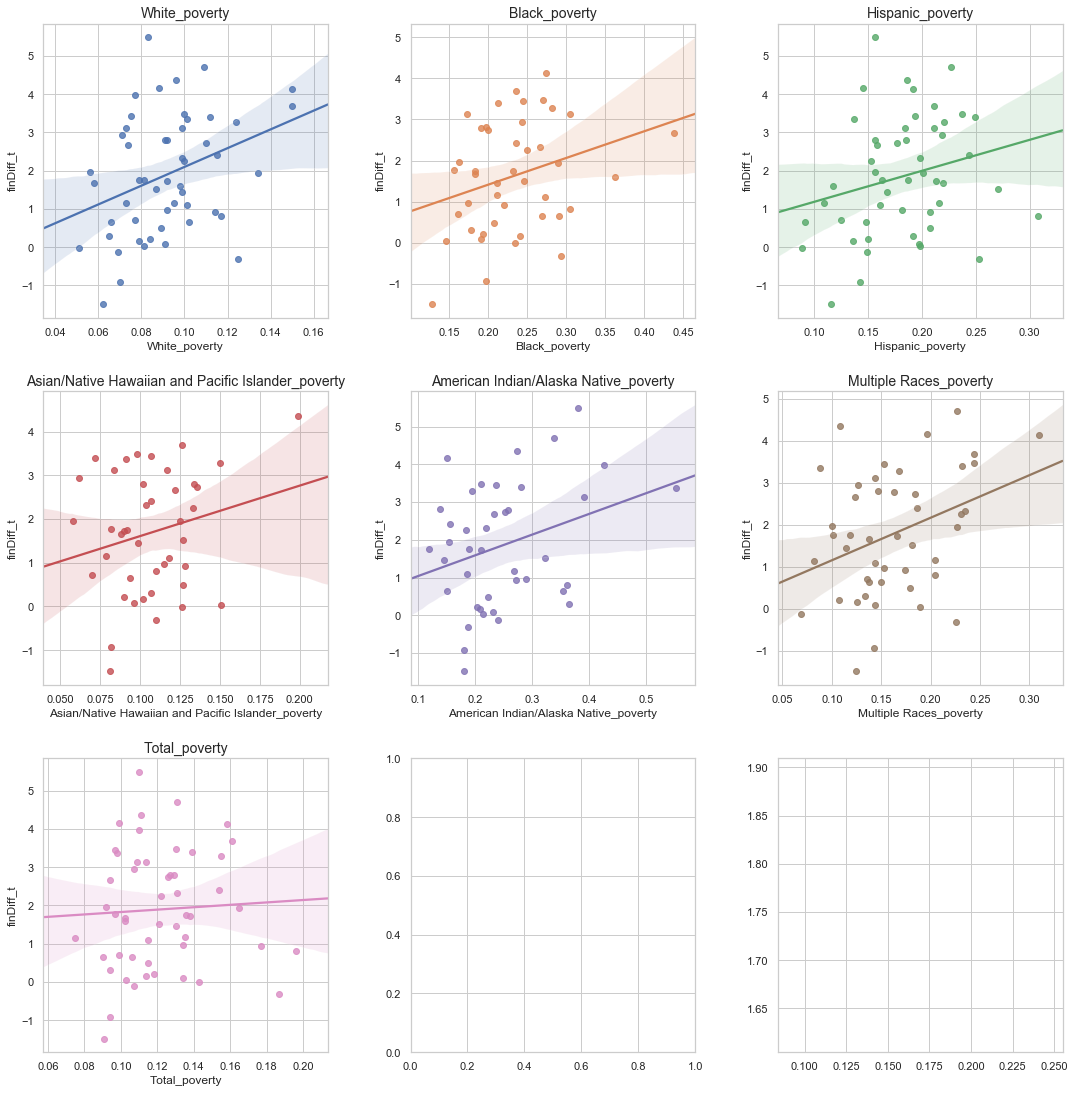

In [193]:
f, ax = plt.subplots(3, 3, figsize=(16,16))
ax = ax.flatten()
f.tight_layout(pad=5)

for n, i in enumerate(p_list) :
    sns.regplot(x=i, y='finDiff_t', data=all_df2, ax=ax[n])
    ax[n].set_title(i, fontsize=14)

* poverty 비율 중 가장 높은 상관관계를 보이는 것은 인종 중에서도 백인임
* 물론, 위 그래프에서도 명확한 상관관계를 보이는 것은 아니나, 백인 poverty ratio가 영향을 미치는 것으로 보이며, 
* 더욱 명확한 관계를 위해서는 더 다양한 변수 발굴이 필요해보임
* 다만, 어떤 인종이든 poverty 비율이 높을 수록 shy trump가 높다는 것은 주목할만 해보임

In [183]:
all_df2[['state','White', 'Median Annual Household Income', 'Income_minmax','White_poverty','finDiff_t']].sort_values(by='finDiff_t', ascending=False)

,state,White,Median Annual Household Income,Income_minmax,White_poverty,finDiff_t
39,North Dakota,0.841,64577.0,0.404205,0.083,5.484260
28,Montana,0.861,57153.0,0.244459,0.109,4.707570
12,Idaho,0.816,60999.0,0.327215,0.096,4.364430
55,Wyoming,0.838,65003.0,0.413371,0.088,4.162400
53,West Virginia,0.925,48850.0,0.065800,0.150,4.134440
46,South Dakota,0.819,59533.0,0.295671,0.077,3.970160
21,ME-2,0.932,58924.0,0.282567,0.102,3.850880
17,Kentucky,0.845,52295.0,0.139928,0.150,3.689510
40,Ohio,0.786,58642.0,0.276499,0.100,3.478330
54,Wisconsin,0.811,64168.0,0.395404,0.075,3.441980


### 결론

* 정리하자면, 예측시 트럼프와 바이든 후보 격차가 클수록 여론조사에서 잡아내지 못한 '샤이 트럼프' 규모도 컸던 거 같음
* 인종별 인구 비중, 소득은 Trump 예측에 영향을 미친 것으로 보임 (성별도)
    1. 백인 인구가 많은 곳일수록 Trump 후보의 실제-예측 결과가 큰 차이가 났고,
    2. 흑인 인구가 많은 곳일수록 Trump 후보의 실제-예측 결과가 적게 차이가 났고, 오히려 Trump 예측이 과대 예측 되었을수도 있음
    3. 위의 관계는 income을 인종별 비중에 곱한 값일수록 더 강하게 보이나,몇몇 주가 해당 경향을 주도하는 것으로 보임
    4. 성별의 경우 남자가 많을 수록 shy trump가 높아 보임
* 위 demographic 정보는 상관관계가 강하지 않고 조금 더 깊은 분석이 필요해보임
    * 그래프를 보면 해당 변수들로 명확한 설명이 되지 않고, 2차적인 요소가 영향을 미치는 게 보임
    * 예를 들어, 백인 비중의 경우에도 해당 주의 백인들의 소득 수준에 따라 그래프가 더 달라질 수 있음
    * 해당 부분 분석을 위해 인종별 poverty 비율을 갖고 온 결과 모든 인종에서 poverty 비율이 높은 주에서는 shy Trump가 높게 나타남
    * 이 중에서도 백인의 poverty 비율의 상관관계가 shy trump와 가장 연관성이 높아 보였음
* 사실 위 분석 결과들은 이미 이전에 분석한 것과 크게 다르지 않으나, 계속 주지했듯 상관관계이며, 그 상관관계도 엄청 강한 변수는 아직 보이지 않음
    * 보다 자세한 분석을 통해 의미를 명확하게 할 필요가 있음
* 언론사들은 위 결과들을 반영했다고 했지만, 반영이 제대로 되지 않았음을 알 수 있음